In [1]:
import os, sys, re, pickle
from tqdm import tqdm
import os.path as osp

import pandas as pd
import numpy as np
from collections import Counter


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from statistics import mean

import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor

In [2]:
traindf_path = "~/INLG-shared-task/PreCogLTRC-HinglishEval-INLG-2022/dataset/traindf.json"
valdf_path = "~/INLG-shared-task/PreCogLTRC-HinglishEval-INLG-2022/dataset/valdf.json"
testdf_file_path = "~/INLG-shared-task/PreCogLTRC-HinglishEval-INLG-2022/dataset/testdf.json"

In [3]:
traindf = pd.read_json(traindf_path)
valdf = pd.read_json(valdf_path)
testdf = pd.read_json(testdf_file_path)

In [4]:
traindf.columns, traindf.shape

(Index(['index', 'English', 'Hindi', 'Hinglish', 'Average rating',
        'Disagreement', 'hum_gen', 'Hinglish_csnliop', 'hum_gen_csnliop',
        'Hinglish_norm', 'Hinglish_lid', 'hum_gen_norm', 'hum_gen_lid',
        'Hinglish_pos', 'hum_gen_pos', 'Hinglish_cmi_scores',
        'Hinglish_burstiness_scores', 'Hinglish_sp_scores', 'symcom_scores_pos',
        'symcom_scores_sent', 'NOUN_symcom', 'AUX_symcom', 'CCONJ_symcom',
        'ADP_symcom', 'NUM_symcom', 'PRON_symcom', 'PART_symcom', 'VERB_symcom',
        'PROPN_symcom', 'SCONJ_symcom', 'ADV_symcom', 'INTJ_symcom',
        'DET_symcom', 'ADJ_symcom', 'symcom_+1_count', 'symcom_-1_count',
        'symcom_na_count', 'symcom_others', 'Hinglish_length',
        'Hingilish_xlmr_scores', 'hum_gen_tokens', 'hum_gen_xlmr_scores'],
       dtype='object'),
 (2766, 42))

In [5]:
valdf.columns, valdf.shape

(Index(['index', 'English', 'Hindi', 'Hinglish', 'hum_gen', 'Hinglish_csnliop',
        'hum_gen_csnliop', 'Hinglish_norm', 'Hinglish_lid', 'hum_gen_norm',
        'hum_gen_lid', 'Hinglish_pos', 'hum_gen_pos', 'Hinglish_cmi_scores',
        'Hinglish_burstiness_scores', 'Hinglish_sp_scores', 'symcom_scores_pos',
        'symcom_scores_sent', 'PRON_symcom', 'ADV_symcom', 'PART_symcom',
        'DET_symcom', 'NOUN_symcom', 'ADP_symcom', 'VERB_symcom', 'AUX_symcom',
        'ADJ_symcom', 'SCONJ_symcom', 'PROPN_symcom', 'CCONJ_symcom',
        'NUM_symcom', 'INTJ_symcom', 'symcom_+1_count', 'symcom_-1_count',
        'symcom_na_count', 'symcom_others', 'hum_gen_tokens',
        'hum_gen_xlmr_scores', 'Hingilish_xlmr_scores'],
       dtype='object'),
 (395, 39))

In [6]:
valdf["Hinglish_length"] = valdf["Hinglish_norm"].apply(len)
testdf["Hinglish_length"] = testdf["Hinglish_norm"].apply(len)


In [7]:
xlm_r_ppl_scores_delta = []

for ind,row in tqdm(traindf.iterrows()):

    try:
        xlm_r_ppl_scores_delta.append(row["Hingilish_xlmr_scores"] - mean(row["hum_gen_xlmr_scores"]))
    except TypeError:
        xlm_r_ppl_scores_delta.append(np.nan)

        
traindf["xlm_r_ppl_scores_delta"] = xlm_r_ppl_scores_delta

2766it [00:00, 11009.76it/s]


In [8]:
xlm_r_ppl_scores_delta = []

for ind,row in tqdm(valdf.iterrows()):

    try:
        xlm_r_ppl_scores_delta.append(row["Hingilish_xlmr_scores"] - mean(row["hum_gen_xlmr_scores"]))
    except TypeError:
        xlm_r_ppl_scores_delta.append(np.nan)

        
valdf["xlm_r_ppl_scores_delta"] = xlm_r_ppl_scores_delta

395it [00:00, 9953.02it/s]


In [9]:
xlm_r_ppl_scores_delta = []

for ind,row in tqdm(testdf.iterrows()):

    try:
        xlm_r_ppl_scores_delta.append(row["Hingilish_xlmr_scores"] - mean(row["hum_gen_xlmr_scores"]))
    except TypeError:
        xlm_r_ppl_scores_delta.append(np.nan)

        
testdf["xlm_r_ppl_scores_delta"] = xlm_r_ppl_scores_delta

791it [00:00, 10857.08it/s]


In [10]:
import numpy as np
import torch
import pickle as pkl
import scipy




In [11]:
trh = torch.load('train.human.pt', map_location=torch.device('cpu')).numpy()
trs = torch.load('train.synth.pt',map_location=torch.device('cpu')).numpy()
teh = torch.load('test.human.pt', map_location=torch.device('cpu')).numpy()
tes = torch.load('test.synth.pt',map_location=torch.device('cpu')).numpy()


In [12]:
from scipy.spatial.distance import euclidean, cityblock


In [13]:
tr_eu = []
tr_ci = []

te_eu = []
te_ci = []

for i in range(len(trh)):
    tr_eu.append(euclidean(trh[i], trs[i]))
    tr_ci.append(cityblock(trh[i], trs[i]))

for i in range(len(teh)):
    te_eu.append(euclidean(teh[i], tes[i]))
    te_ci.append(euclidean(teh[i], tes[i]))

traindf["eucl"] = tr_eu
traindf["cityblock"] = tr_ci

testdf["eucl"], testdf["cityblock"]  = te_eu, te_ci

In [14]:
trh = torch.load('train.human.pt', map_location=torch.device('cpu'))
trs = torch.load('train.synth.pt',map_location=torch.device('cpu'))
teh = torch.load('test.human.pt', map_location=torch.device('cpu'))
tes = torch.load('test.synth.pt',map_location=torch.device('cpu'))


cosine_train = torch.nn.CosineSimilarity(dim = 1)(trs, trh)
cosine_test = torch.nn.CosineSimilarity(dim = 1)(tes, teh)

traindf["cosine"] = cosine_train.numpy()
testdf["cosine"] = cosine_test.numpy()

In [15]:
len(tr_eu), len(te_eu)

(2766, 791)

In [16]:
traindf.columns

Index(['index', 'English', 'Hindi', 'Hinglish', 'Average rating',
       'Disagreement', 'hum_gen', 'Hinglish_csnliop', 'hum_gen_csnliop',
       'Hinglish_norm', 'Hinglish_lid', 'hum_gen_norm', 'hum_gen_lid',
       'Hinglish_pos', 'hum_gen_pos', 'Hinglish_cmi_scores',
       'Hinglish_burstiness_scores', 'Hinglish_sp_scores', 'symcom_scores_pos',
       'symcom_scores_sent', 'NOUN_symcom', 'AUX_symcom', 'CCONJ_symcom',
       'ADP_symcom', 'NUM_symcom', 'PRON_symcom', 'PART_symcom', 'VERB_symcom',
       'PROPN_symcom', 'SCONJ_symcom', 'ADV_symcom', 'INTJ_symcom',
       'DET_symcom', 'ADJ_symcom', 'symcom_+1_count', 'symcom_-1_count',
       'symcom_na_count', 'symcom_others', 'Hinglish_length',
       'Hingilish_xlmr_scores', 'hum_gen_tokens', 'hum_gen_xlmr_scores',
       'xlm_r_ppl_scores_delta', 'eucl', 'cityblock', 'cosine'],
      dtype='object')

# columns MinMax scaling normalisation

In [17]:
def standarize_cols(df, cols_to_be_standardized, newcolnames):
    
    X = df[cols_to_be_standardized]
    coldata_numpy_reshaped = X.to_numpy()
    scale = StandardScaler().fit(coldata_numpy_reshaped)        
    transformed_coldata = scale.transform(coldata_numpy_reshaped)
    df = pd.concat([df, pd.DataFrame(transformed_coldata, columns = newcolnames)], axis=1)
    return df

def normalize_cols(df, cols_to_be_normalised, newcolnames):
    
    X = df[cols_to_be_normalised]
    coldata_numpy_reshaped = X.to_numpy()
    norm = MinMaxScaler().fit(coldata_numpy_reshaped)    
    transformed_coldata = norm.transform(coldata_numpy_reshaped)
    df = pd.concat([df, pd.DataFrame(transformed_coldata, columns = newcolnames)], axis=1)
    return df, norm


def transform_normalize_cols(df, cols_to_be_normalised, newcolnames, normalizer):
    
    X = df[cols_to_be_normalised]
    coldata_numpy_reshaped = X.to_numpy()
    # norm = MinMaxScaler().fit(coldata_numpy_reshaped)    
    transformed_coldata = normalizer.transform(coldata_numpy_reshaped)
    df = pd.concat([df, pd.DataFrame(transformed_coldata, columns = newcolnames)], axis=1)
    return df


In [19]:
def generate_colnames_withSuffix(colnames, suffix ):
    newcolnames = []
    for col in colnames:
        newcolnames.append(col+'_'+suffix)
        
    return newcolnames

cols_to_be_standardized = ['Hinglish_cmi_scores',
                           'Hinglish_burstiness_scores',
                           'Hinglish_sp_scores', 
                           'symcom_scores_sent',
                           'NOUN_symcom',
                           'AUX_symcom',
                           'CCONJ_symcom',
                           'ADP_symcom',
                           'NUM_symcom',
                           'PRON_symcom',
                           'PART_symcom',
                           'VERB_symcom',
                           'PROPN_symcom',
                           'SCONJ_symcom', 
                           'ADV_symcom',
                           'INTJ_symcom',
                           'DET_symcom',
                           'ADJ_symcom',
                           'symcom_+1_count',
                           'symcom_-1_count',
                           'symcom_na_count', 
                           'symcom_others',
                           'xlm_r_ppl_scores_delta',
                           'Hinglish_length',
                           'eucl', 
                           'cityblock', 
                           'cosine'
                          ]

traindf_standard_all, normalizer_train = normalize_cols(
                                    df = traindf, 
                                    cols_to_be_normalised = cols_to_be_standardized,
                                    newcolnames = generate_colnames_withSuffix(cols_to_be_standardized, 
                                                                     suffix = 'standardized'))


# valdf_standard_all = transform_normalize_cols(
#                                     df = valdf, 
#                                     cols_to_be_normalised = cols_to_be_standardized,
#                                     newcolnames = generate_colnames_withSuffix(cols_to_be_standardized, 
#                                                                      suffix = 'standardized'),
#                                     normalizer = normalizer_train)


testdf_standard_all = transform_normalize_cols(
                                    df = testdf, 
                                    cols_to_be_normalised = cols_to_be_standardized,
                                    newcolnames = generate_colnames_withSuffix(cols_to_be_standardized, 
                                                                     suffix = 'standardized'),
                                    normalizer = normalizer_train)



In [20]:
traindf_standard_all.columns

Index(['index', 'English', 'Hindi', 'Hinglish', 'Average rating',
       'Disagreement', 'hum_gen', 'Hinglish_csnliop', 'hum_gen_csnliop',
       'Hinglish_norm', 'Hinglish_lid', 'hum_gen_norm', 'hum_gen_lid',
       'Hinglish_pos', 'hum_gen_pos', 'Hinglish_cmi_scores',
       'Hinglish_burstiness_scores', 'Hinglish_sp_scores', 'symcom_scores_pos',
       'symcom_scores_sent', 'NOUN_symcom', 'AUX_symcom', 'CCONJ_symcom',
       'ADP_symcom', 'NUM_symcom', 'PRON_symcom', 'PART_symcom', 'VERB_symcom',
       'PROPN_symcom', 'SCONJ_symcom', 'ADV_symcom', 'INTJ_symcom',
       'DET_symcom', 'ADJ_symcom', 'symcom_+1_count', 'symcom_-1_count',
       'symcom_na_count', 'symcom_others', 'Hinglish_length',
       'Hingilish_xlmr_scores', 'hum_gen_tokens', 'hum_gen_xlmr_scores',
       'xlm_r_ppl_scores_delta', 'eucl', 'cityblock', 'cosine',
       'Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized', 'symcom_scores_sent_

# Linear Regression

In [8]:
X = traindf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]


sim = SimpleImputer(missing_values=np.nan, strategy='mean')

X_imputed_data = sim.fit_transform(X.values)

y = traindf_standard_all["Average rating"]

model = sm.OLS(y, X_imputed_data).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Average rating   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     14.95
Date:                Thu, 05 May 2022   Prob (F-statistic):           6.86e-51
Time:                        17:22:35   Log-Likelihood:                -5093.7
No. Observations:                2766   AIC:                         1.023e+04
Df Residuals:                    2744   BIC:                         1.036e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4323      0.207     -2.086      0.037      -0.839      -0.026
x2            -0.6985      0.247     -2.832      0.005      -1.182      -0.215
x3            -0.5189      0.568     -0.914      0.361      -1.632       0.594
x4             0.0876      0.236      0.371      0.711      -0.375       0.551
x5             0.6767      0.152      4.459      0.000       0.379       0.974
x6            -0.3686      0.258     -1.429      0.153      -0.875       0.137
x7             0.3801      0.200      1.898      0.058      -0.013       0.773
x8            -0.3724      0.239     -1.561      0.119      -0.840       0.095
x9            -0.6349      0.292     -2.177      0.030      -1.207      -0.063
x10           -0.3965      0.218     -1.821      0.069      -0.823       0.030
x11           -0.5467      0.346     -1.582      0.114      -1.224       0.131
x12           -0.8484      0.162     -5.236      0.000      -1.166      -0.531
x13            0.0864      0.182      0.475      0.635      -0.270       0.443
x14            1.1002      0.623      1.766      0.077      -0.121       2.322
x15            0.1240      0.186      0.666      0.506      -0.241       0.489
x16            0.4521      0.561      0.806      0.420      -0.647       1.551
x17           -0.5215      0.198     -2.630      0.009      -0.910      -0.133
x18            0.4764      0.126      3.775      0.000       0.229       0.724
x19            2.4531      0.632      3.884      0.000       1.215       3.692
x20            6.8720      0.382     17.974      0.000       6.122       7.622
x21            7.1801      0.346     20.736      0.000       6.501       7.859
x22            3.4884      0.530      6.584      0.000       2.449       4.527
==============================================================================
Omnibus:                      113.138   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.545
Skew:                          -0.521   Prob(JB):                     3.32e-28
Kurtosis:                       2.898   Cond. No.                         50.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
X_test = valdf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]

X_test_imputed_data = sim.transform(X_test.values)


predictions = model.predict(X_test_imputed_data)

print(predictions)

[7.72367966 7.25611928 7.59534325 8.27092481 8.04115035 8.03152276
 7.79015719 8.18182958 7.7491748  8.15335766 7.96115563 7.79243623
 7.98787927 8.05301394 8.35074987 8.58076587 8.09046664 8.23270498
 7.7082036  7.89769649 8.00664459 7.80830179 8.43871955 6.7369382
 8.00550666 8.01857482 7.85489869 8.13479472 8.55225542 8.26357656
 7.89524672 8.05550842 8.12152523 8.45850859 8.20581007 7.8662736
 8.15289094 7.76448913 7.89763385 7.66222091 8.1972876  8.13590462
 7.47554386 6.93192045 8.28816652 8.29637852 8.1576895  8.12978965
 7.32447733 8.09079482 7.77313057 8.00816427 8.19986355 8.30760543
 7.9275712  8.56325642 7.17911105 8.46180253 7.56755202 8.51923659
 7.88981949 8.2995073  7.76279733 8.01018149 8.28484042 8.18247716
 8.25554127 8.64957901 8.20214984 8.04617026 7.7760569  8.11836409
 7.76431529 7.73176561 7.89781799 8.30845445 7.85375075 8.02968614
 8.34788382 8.18112479 8.25411123 8.30093772 7.58773765 7.71922583
 8.26146494 7.74478939 7.74735673 8.11961063 7.60023816 8.014583

In [14]:
X = traindf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]


sim = SimpleImputer(missing_values=np.nan, strategy='mean')

X_imputed_data = sim.fit_transform(X.values)

y = traindf_standard_all["Disagreement"]

model = sm.OLS(y, X_imputed_data).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Disagreement   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     10.81
Date:                Thu, 05 May 2022   Prob (F-statistic):           6.79e-35
Time:                        17:23:50   Log-Likelihood:                -5568.4
No. Observations:                2766   AIC:                         1.118e+04
Df Residuals:                    2744   BIC:                         1.131e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0221      0.246      0.090      0.928      -0.460       0.505
x2            -0.1409      0.293     -0.481      0.630      -0.715       0.433
x3            -0.1924      0.674     -0.286      0.775      -1.514       1.129
x4             0.4496      0.280      1.604      0.109      -0.100       0.999
x5            -1.3302      0.180     -7.384      0.000      -1.683      -0.977
x6            -0.1778      0.306     -0.580      0.562      -0.778       0.423
x7            -0.7383      0.238     -3.105      0.002      -1.204      -0.272
x8             0.2958      0.283      1.044      0.297      -0.260       0.851
x9             0.2720      0.346      0.786      0.432      -0.407       0.951
x10           -0.3807      0.259     -1.473      0.141      -0.888       0.126
x11            0.4622      0.410      1.127      0.260      -0.342       1.267
x12            0.0755      0.192      0.392      0.695      -0.302       0.453
x13           -0.0604      0.216     -0.280      0.780      -0.484       0.363
x14           -0.7916      0.740     -1.070      0.285      -2.242       0.659
x15           -0.1454      0.221     -0.657      0.511      -0.579       0.288
x16           -0.3233      0.666     -0.486      0.627      -1.628       0.982
x17           -0.0631      0.235     -0.268      0.789      -0.525       0.398
x18           -0.6410      0.150     -4.278      0.000      -0.935      -0.347
x19            2.5583      0.750      3.412      0.001       1.088       4.029
x20            3.2525      0.454      7.165      0.000       2.362       4.143
x21            2.6236      0.411      6.382      0.000       1.817       3.430
x22            2.4992      0.629      3.973      0.000       1.266       3.733
==============================================================================
Omnibus:                      285.751   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              378.283
Skew:                           0.870   Prob(JB):                     7.19e-83
Kurtosis:                       3.507   Cond. No.                         50.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/prashantk/miniconda3/envs/cm/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


<AxesSubplot:>

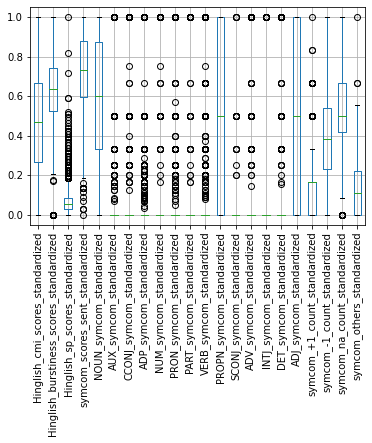

In [16]:
subdf = traindf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized', 'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]

for col in subdf.columns:
    subdf[col] = pd.to_numeric(traindf_standard_all[col],errors='coerce')

subdf.boxplot(rot=90)

In [25]:
traindf.columns

Index(['level_0', 'English', 'Hindi', 'Hinglish', 'Average rating',
       'Disagreement', 'hum_gen', 'Hinglish_csnliop', 'hum_gen_csnliop',
       'Hinglish_norm', 'Hinglish_lid', 'hum_gen_norm', 'hum_gen_lid',
       'Hinglish_pos', 'hum_gen_pos', 'Hinglish_cmi_scores',
       'Hinglish_burstiness_scores', 'Hinglish_sp_scores', 'symcom_scores_pos',
       'symcom_scores_sent', 'NOUN_symcom', 'AUX_symcom', 'CCONJ_symcom',
       'ADP_symcom', 'NUM_symcom', 'PRON_symcom', 'PART_symcom', 'VERB_symcom',
       'PROPN_symcom', 'SCONJ_symcom', 'ADV_symcom', 'INTJ_symcom',
       'DET_symcom', 'ADJ_symcom', 'symcom_+1_count', 'symcom_-1_count',
       'symcom_na_count', 'symcom_others'],
      dtype='object')

# MLP Regressor

In [21]:
X = traindf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized',
       'xlm_r_ppl_scores_delta_standardized', 'Hinglish_length_standardized',
         'eucl_standardized', 'cityblock_standardized', 'cosine_standardized']]


sim = SimpleImputer(missing_values=np.nan, strategy='mean')

X_imputed_data = sim.fit_transform(X.values)

y = traindf_standard_all["Average rating"]


regr = MLPRegressor(random_state=1, max_iter=10000, verbose = True).fit(X_imputed_data, y)


X_test = testdf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized',
        'xlm_r_ppl_scores_delta_standardized', 'Hinglish_length_standardized',
         'eucl_standardized', 'cityblock_standardized', 'cosine_standardized']]

X_test_imputed = sim.transform(X_test)

predictions_test = regr.predict(X_test_imputed)

predictions_test_round = [round(el) for el in predictions_test]

Iteration 1, loss = 24.17801430
Iteration 2, loss = 18.40914474
Iteration 3, loss = 12.78391379
Iteration 4, loss = 7.55434110
Iteration 5, loss = 3.77167871
Iteration 6, loss = 2.02359593
Iteration 7, loss = 1.67999240
Iteration 8, loss = 1.66381776
Iteration 9, loss = 1.62706232
Iteration 10, loss = 1.59530208
Iteration 11, loss = 1.57124633
Iteration 12, loss = 1.54762647
Iteration 13, loss = 1.52645700
Iteration 14, loss = 1.50590332
Iteration 15, loss = 1.48658055
Iteration 16, loss = 1.46771125
Iteration 17, loss = 1.45144905
Iteration 18, loss = 1.43519376
Iteration 19, loss = 1.42062776
Iteration 20, loss = 1.40611770
Iteration 21, loss = 1.39247877
Iteration 22, loss = 1.38002538
Iteration 23, loss = 1.36825381
Iteration 24, loss = 1.35658467
Iteration 25, loss = 1.34496287
Iteration 26, loss = 1.33384294
Iteration 27, loss = 1.32222242
Iteration 28, loss = 1.31047679
Iteration 29, loss = 1.29858348
Iteration 30, loss = 1.28593783
Iteration 31, loss = 1.27409927
Iteration 32, 

/home/prashantk/miniconda3/envs/cm/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [22]:
with open('test_predictions_avg_rating.txt','w') as f:
    for el in predictions_test_round:
        f.write(str(el)+"\n")

In [23]:
len(open('test_predictions_avg_rating.txt','r').readlines())

791

In [24]:
X = traindf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized',
        'xlm_r_ppl_scores_delta_standardized', 'Hinglish_length_standardized',
                         'eucl_standardized', 'cityblock_standardized', 'cosine_standardized']]


sim = SimpleImputer(missing_values=np.nan, strategy='mean')

X_imputed_data = sim.fit_transform(X.values)

y = traindf_standard_all["Disagreement"]


regr = MLPRegressor(random_state=1, max_iter=10000, verbose = True).fit(X_imputed_data, y)


X_test = testdf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized',
        'xlm_r_ppl_scores_delta_standardized', 'Hinglish_length_standardized',
                            'eucl_standardized', 'cityblock_standardized', 'cosine_standardized']]

X_test_imputed = sim.transform(X_test)

predictions_test = regr.predict(X_test_imputed)

predictions_test_round = [round(el) for el in predictions_test]

Iteration 1, loss = 3.71877854
Iteration 2, loss = 2.42902651
Iteration 3, loss = 1.88188967
Iteration 4, loss = 1.82898339
Iteration 5, loss = 1.78475296
Iteration 6, loss = 1.75189929
Iteration 7, loss = 1.72655204
Iteration 8, loss = 1.70380681
Iteration 9, loss = 1.68905646
Iteration 10, loss = 1.67504873
Iteration 11, loss = 1.66445552
Iteration 12, loss = 1.65568996
Iteration 13, loss = 1.64963205
Iteration 14, loss = 1.64669183
Iteration 15, loss = 1.63994020
Iteration 16, loss = 1.63769006
Iteration 17, loss = 1.63415561
Iteration 18, loss = 1.63111488
Iteration 19, loss = 1.62979319
Iteration 20, loss = 1.62713072
Iteration 21, loss = 1.62500184
Iteration 22, loss = 1.62296043
Iteration 23, loss = 1.62059179
Iteration 24, loss = 1.62034718
Iteration 25, loss = 1.61770410
Iteration 26, loss = 1.61674766
Iteration 27, loss = 1.61889456
Iteration 28, loss = 1.61459864
Iteration 29, loss = 1.61071372
Iteration 30, loss = 1.61234885
Iteration 31, loss = 1.61009674
Iteration 32, los

/home/prashantk/miniconda3/envs/cm/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [25]:
with open('test_predictions_avg_rating.txt','a') as f:
    for el in predictions_test_round:
        f.write(str(el)+"\n")

In [26]:
len(open('test_predictions_avg_rating.txt','r').readlines())

1582

# test predictions

In [27]:

traindf.to_json(traindf_path)
testdf.to_json(testdf_file_path)